#### Importing the model and getting the output values of the pep-encoder

##### Setting up the constants and imports:

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from modelAndPerformances import *
import seaborn as sns
from hyperparametricSelection import hyperparameterSelection

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#samples to plot
N = 200
#model constants
d_model = 64
d_ff = 512
# Load model hyperparameters and data
n_heads, n_layers, d_k = hyperparameterSelection()

The best hyperparameters are: n_heads: 6.0, n_layers = 4.0, d_k = 32.0


#### Using some guidelines for good plots settings from a course at Imperial

In [14]:
# we define a mix of fontsizes, for different parts of a plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# example of how you can use these fontsizes to set a global configuration for matplotlib;
# you should assign them based on the specific appearance of the figures you are producing
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#setting seeds
seed = 6
random.seed(seed )
torch.manual_seed(seed )
np.random.seed(seed ) 

##### Setting up required masks and making data smaller (more maneagable)

In [15]:
data = pd.read_csv('data/trainDataFull/fullTrainingData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

# Filter only positive labels
positive_mask = labels == 1
pep_pos = pep_inputs[positive_mask]
hla_pos = hla_inputs[positive_mask]
labels_pos = labels[positive_mask]
labelsHla_pos = labelsHla[positive_mask]  # numpy array of strings

# Select 5 random HLA alleles from the positive samples
unique_hlas = np.unique(labelsHla_pos)
selected_hlas = np.random.choice(unique_hlas, size=5, replace=False)

# Prepare lists to accumulate sampled data
pep_list = []
hla_list = []
labels_list = []
labelsHla_list = []

for hla in selected_hlas:
    # Mask for current HLA allele
    hla_mask = labelsHla_pos == hla

    # Filter data for this HLA
    pep_hla = pep_pos[hla_mask]
    hla_hla = hla_pos[hla_mask]
    labels_hla = labels_pos[hla_mask]
    labelsHla_hla = labelsHla_pos[hla_mask]

    # Number to sample from this HLA
    num_samples_hla = min(N, len(pep_hla))

    # Random sample indices
    indices = torch.randperm(len(pep_hla))[:num_samples_hla]

    # Append sampled data to lists
    pep_list.append(pep_hla[indices])
    hla_list.append(hla_hla[indices])
    labels_list.append(labels_hla[indices])
    labelsHla_list.append(labelsHla_hla[indices])

# Concatenate samples from all HLAs
pepSmall = torch.cat(pep_list).to(device)
hlaSmall = torch.cat(hla_list).to(device)
labelsSmall = torch.cat(labels_list)
labelsSmallHla = np.concatenate(labelsHla_list)


##### Make hook to store pep_encoder information

In [16]:
# Load model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff)
model.load_state_dict(torch.load("model/best_model.pt", map_location=device))
model.to(device)
model.eval()

# Hook to extract encoder outputs
pepEncoderOutputs = {}
def get_activation(name):
    def hook(model, input, output):
        pepEncoderOutputs["pep"] = output[0].detach()
    return hook

model.pep_encoder.register_forward_hook(get_activation("pep_encoder"))

# Forward pass
model(pepSmall, hlaSmall)
pepEncoderOutputs = pepEncoderOutputs["pep"]  


##### Make hook to store decoder information

In [17]:
# Extract encoder outputs using forward hook
decOutputs = {}

def get_activation(name):
    def hook(model, input, output):
        decOutputs["dec"] = output[0].detach()
    return hook
# Load and prepare model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff)
model.load_state_dict(torch.load("model/best_model.pt", map_location=device))
model.to(device)
model.eval()
model.decoder.register_forward_hook(get_activation("decoder"))

# Forward pass
model(pepSmall, hlaSmall)
decOutputs = decOutputs["dec"]


##### Prepare both for plotting

In [18]:
# Average over sequence dimension
from sklearn.neighbors import LocalOutlierFactor
pepEncoderOutputs = torch.flatten(pepEncoderOutputs, -2)
decOutputs = torch.flatten(decOutputs, -2)
reducer3d = umap.UMAP(n_components=3)
reducer2d = umap.UMAP(n_components=2)

encoderUmap2d = reducer2d.fit_transform(pepEncoderOutputs)
encoderUmap3d = reducer3d.fit_transform(pepEncoderOutputs)

decoderUmap2d = reducer2d.fit_transform(decOutputs)
decoderUmap3d = reducer3d.fit_transform(decOutputs)

#removing outliers
def removeOutliers(embedding, labels, percentageOfOutliers, n_neighbors = 50):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=percentageOfOutliers/100)
    outlier_preds = lof.fit_predict(embedding)

    # Keep only inliers (where prediction == 1)
    inlier_mask = outlier_preds == 1
    embeddings_filtered = embedding[inlier_mask]
    labels_filtered = np.array(labels)[inlier_mask]
    return embeddings_filtered, labels_filtered

#### Making palette with some imperial colours (and some non imperial colours)

In [19]:
colors = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']

# Create a seaborn palette from these colors
custom_palette = sns.color_palette(colors)

#percentage of outliers constant
percentageOfOutliers = 5

#### Dimensionality Reduction via MDS showing Encoder outputs. Using Seaborn

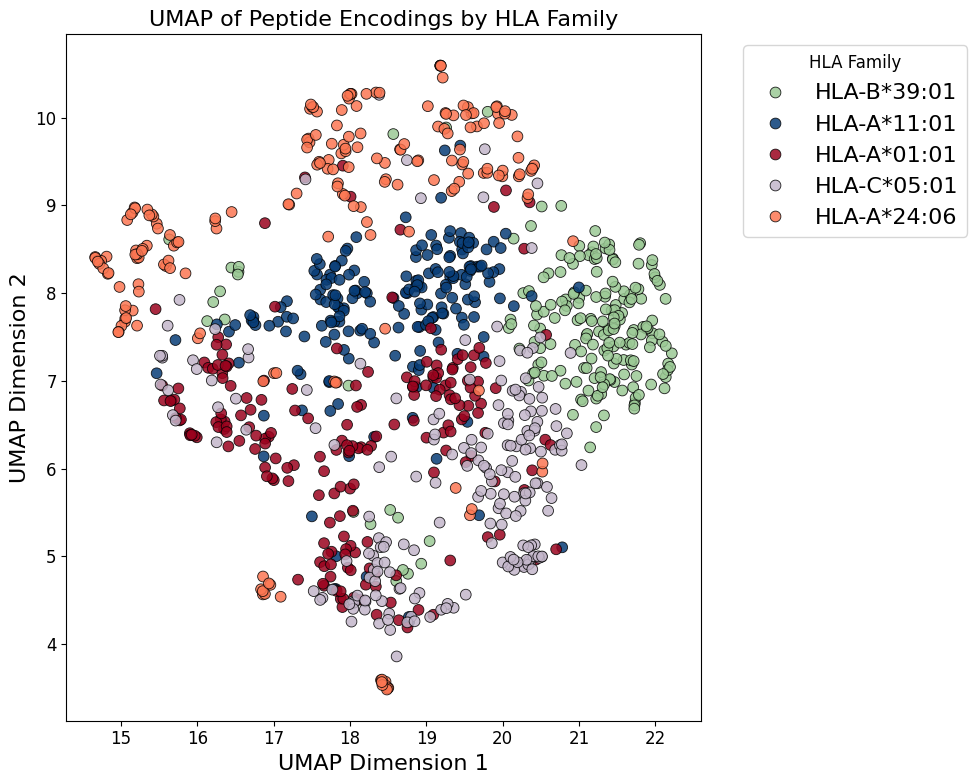

In [28]:
def plot_umap_by_family(embeddingsUMAP, families, title="UMAP of Peptide Encodings by HLA Family"):

    # Prepare dataframe for seaborn plotting
    df = pd.DataFrame({
        'UMAP1': embeddingsUMAP[:, 0],
        'UMAP2': embeddingsUMAP[:, 1],
        'Family': families
    })

    plt.figure(figsize=(10, 8))
    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))


    sns.scatterplot(
        data=df,
        x='UMAP1', y='UMAP2',
        hue='Family',
        palette=palette,
        edgecolor='k',
        s=60,
        alpha=0.85
    )

    plt.title(title, fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="HLA Family", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()

# Plot
plot_umap_by_family(encoderUmap2d,labelsSmallHla)

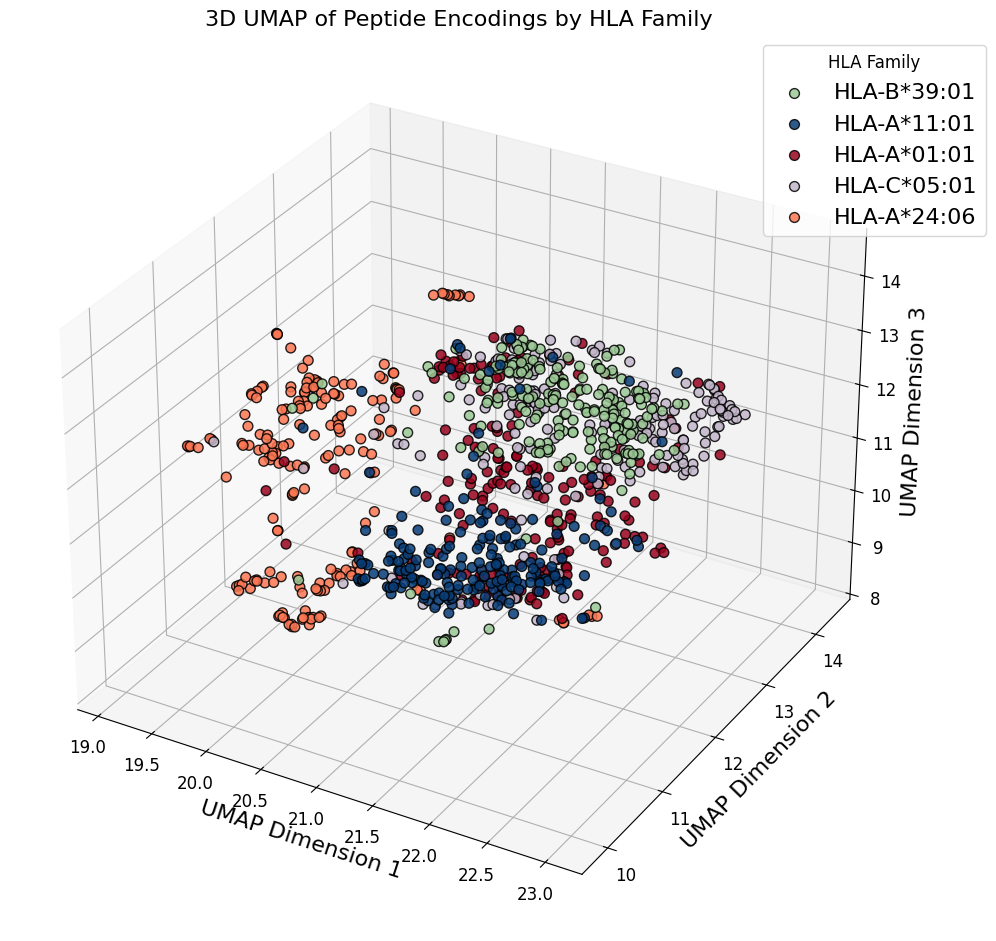

In [27]:
def plot_umap_3d(embeddingsUMAP, families, title="3D UMAP of Peptide Encodings by HLA Family"):

    df = pd.DataFrame({
        'UMAP1': embeddingsUMAP[:, 0],
        'UMAP2': embeddingsUMAP[:, 1],
        'UMAP3': embeddingsUMAP[:, 2],
        'Family': families
    })

    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))
    color_dict = dict(zip(unique_families, palette))

    fig = plt.figure(figsize=(10, 18))
    ax = fig.add_subplot(111, projection='3d')

    for fam in unique_families:
        data_fam = df[df['Family'] == fam]
        ax.scatter(
            data_fam['UMAP1'], data_fam['UMAP2'], data_fam['UMAP3'],
            label=fam,
            color=color_dict[fam],
            edgecolor='k',
            s=50,
            alpha=0.85
        )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.set_zlabel("UMAP Dimension 3")
    ax.legend(title="HLA Family", bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    plt.show()

plot_umap_3d(encoderUmap3d,labelsSmallHla,  )

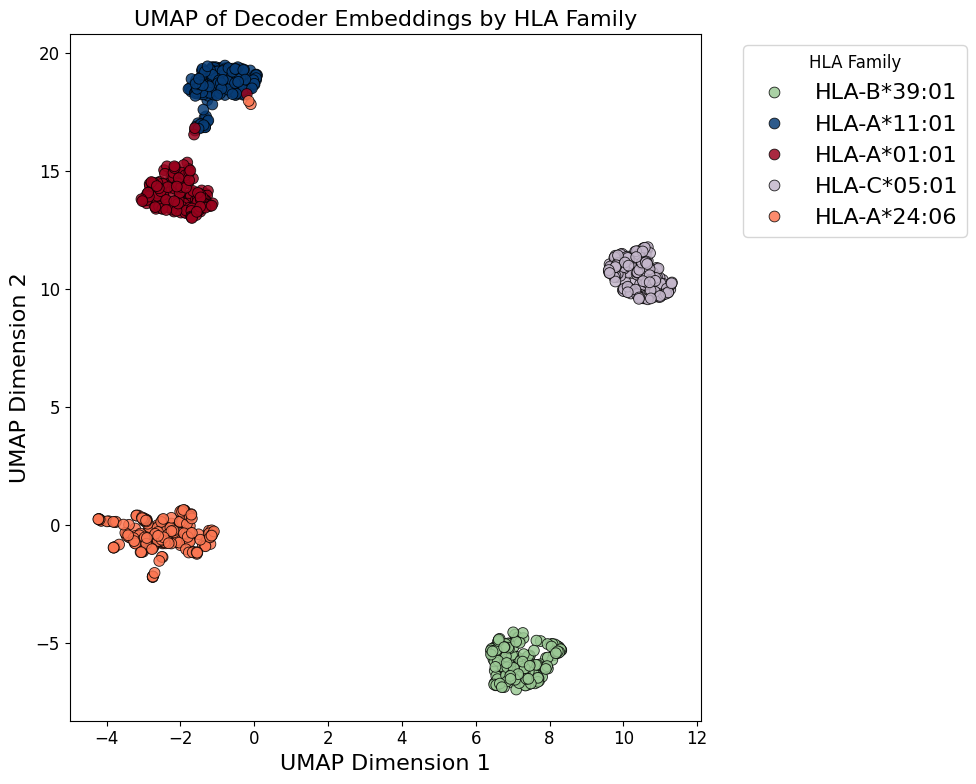

In [26]:
plot_umap_by_family(decoderUmap2d,labelsSmallHla, title= "UMAP of Decoder Embeddings by HLA Family")

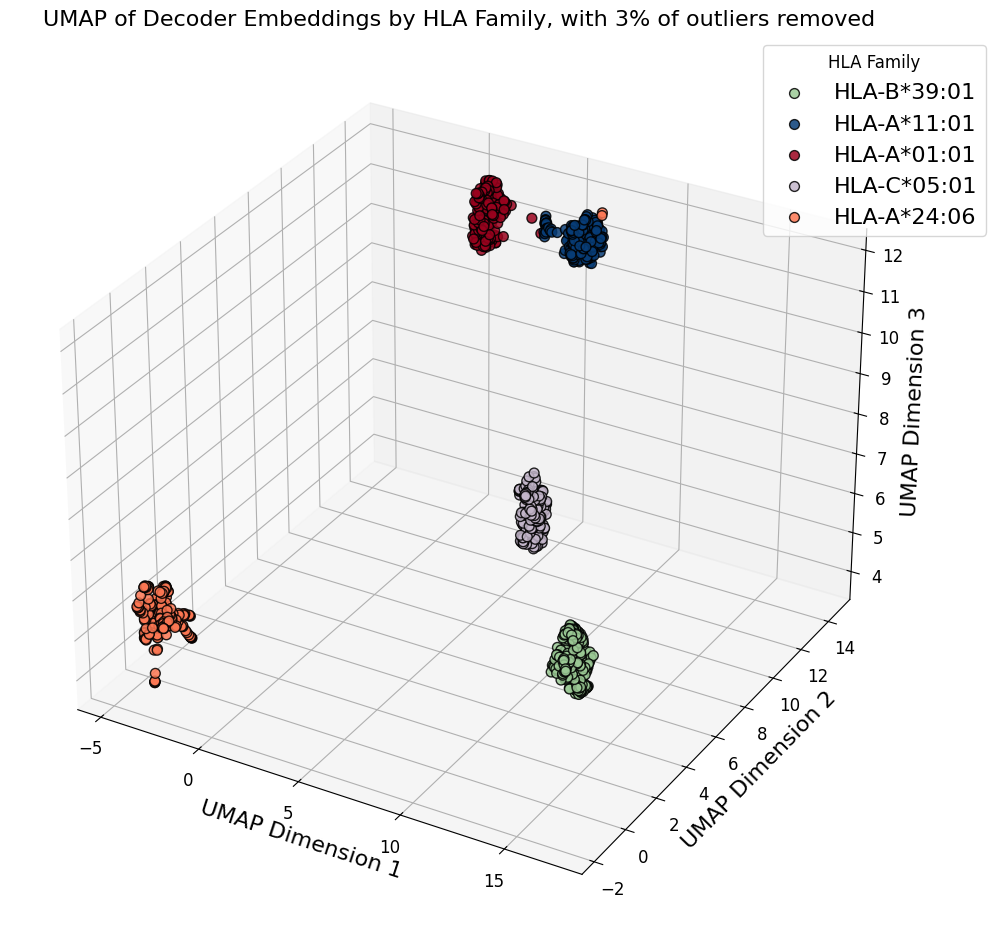

In [ ]:
plot_umap_3d(decoderUmap3d,labelsSmallHla,  title= "UMAP of Decoder Embeddings by HLA Family, with " + str(3) +"% of outliers removed")

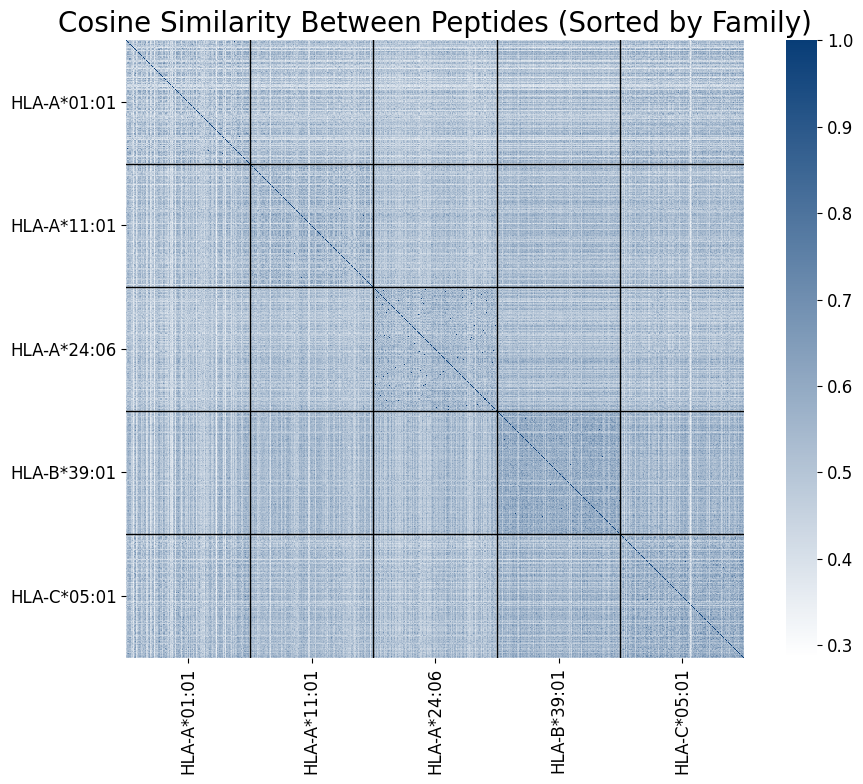

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LinearSegmentedColormap

# Encode labels to numeric for sorting
labelEncoder = LabelEncoder()
labelIds = labelEncoder.fit_transform(labelsSmallHla)
sortedIndices = np.argsort(labelIds)

# Step 2: Sort embeddings and labels
embeddingsSorted = pepEncoderOutputs[sortedIndices]
labelsSorted = np.array(labels)[sortedIndices]
labelIdsSorted = labelIds[sortedIndices]

# Step 3: Compute cosine similarity matrix
simMatrix = cosine_similarity(embeddingsSorted)
adjustedSim = np.power(simMatrix, 5)

# Step 4: Plot heatmap with family boundaries
plt.figure(figsize=(10, 8))
white_blue = LinearSegmentedColormap.from_list("white_blue", ["white",  "#083D77"])
sns.heatmap(adjustedSim, cmap=white_blue, square=True, xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Between Peptides (Sorted by Family)")

# Step 5: Draw lines to show family boundaries
familySizes = np.bincount(labelIdsSorted)
boundaryPositions = np.cumsum(familySizes)

# Use LabelEncoder's classes (sorted unique labels) instead of unique from labelsSorted
uniqueLabels = labelEncoder.classes_

# Compute midpoints for label placement on axes
startIndices = np.insert(boundaryPositions[:-1], 0, 0)
endIndices = boundaryPositions
midpoints = (startIndices + endIndices) // 2

plt.xticks(midpoints, uniqueLabels, rotation=90)
plt.yticks(midpoints, uniqueLabels)

# Draw boundary lines
for pos in boundaryPositions[:-1]:  # skip the last position
    plt.axhline(pos, color='black', linewidth=1)
    plt.axvline(pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()
